## Import Libraries

In [ ]:
!pip install keras

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import json
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Display Sample Images

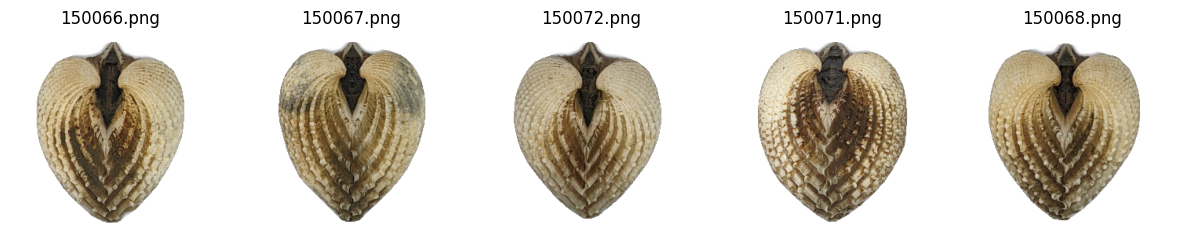

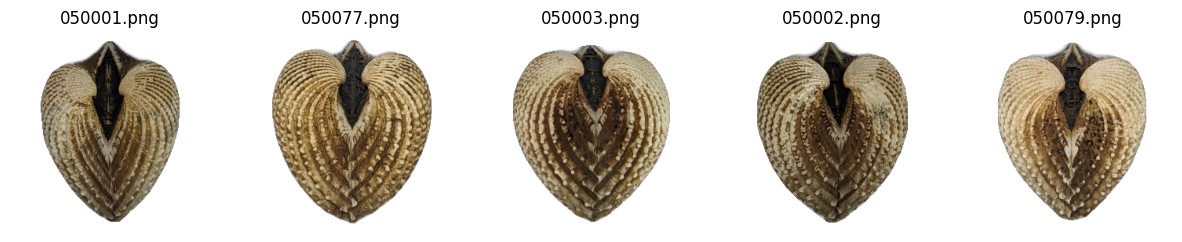

In [4]:
# Define paths to the male and female datasets
male_litob = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/Male"
female_litob = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/Female"

# Get list of image files in male folder
image_files_male = [f for f in os.listdir(male_litob)
                    if os.path.isfile(os.path.join(male_litob, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Display first 5 images from male dataset
num_images_to_show = min(5, len(image_files_male))

plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    img_path = os.path.join(male_litob, image_files_male[i])
    img = mpimg.imread(img_path)
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(image_files_male[i])
    plt.axis('off')

plt.show()

# Get list of image files in female folder
image_files_female = [f for f in os.listdir(female_litob)
                      if os.path.isfile(os.path.join(female_litob, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Display first 5 images from female dataset
plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    img_path = os.path.join(female_litob, image_files_female[i])
    img = mpimg.imread(img_path)
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(image_files_female[i])
    plt.axis('off')

plt.show()

## **TRAIN CNN**

In [5]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.model_selection import KFold

tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
# train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"
train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
        )

    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels).astype(np.float32)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height,3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=30,
    num_folds=5
):
    seed_and_environment()
    image_files, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc':[]
    }

    for fold_no, (train_idx, test_idx) in enumerate(kfold.split(image_files, labels), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        # Train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

        )
        fold_history.append(history)

        # Evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.4f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr,_ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))


        # Store metrics
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['auc'].append(roc_auc)

        # Append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)


    # Display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
      print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
      print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
      print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
      print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
      print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.4f} (±{np.std(loss_per_fold):.4f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# Run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# Save the model
# trained_model.save('gender_classifier_model')

# model summary
model.summary()

Found 271 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.4551 - auc: 0.4958 - loss: 2.1316 - precision: 0.4067 - recall: 0.4016 - val_accuracy: 0.4182 - val_auc: 0.6923 - val_loss: 0.7308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.4660 - auc: 0.5344 - loss: 0.7174 - precision: 0.4281 - recall: 0.4248 - val_accuracy: 0.5818 - val_auc: 0.6719 - val_loss: 0.6830 - val_precision: 0.5818 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5365 - auc: 0.6639 - loss: 0.6860 - precision: 0.5357 - recall: 0.9762 - val_accuracy: 0.6000 - val_auc: 0.7310 - val_loss: 0.6842 - val_precision: 0.7083 - val_recall: 0.5312
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7234 - auc: 0.7297 - loss: 0.6757 - precision: 0.6903 - recall: 0.9000 - val_accuracy: 0.5818 - val_auc: 0.7249 - val_loss: 0.6769 - val_precision: 0.7143 - val_recall: 0.4688
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.5202 - auc: 0.5807 - loss: 2.5709 - precision: 0.5991 - recall: 0.3552 - val_accuracy: 0.4815 - val_auc: 0.6532 - val_loss: 0.6926 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.5034 - auc: 0.6250 - loss: 0.6992 - precision: 0.4442 - recall: 0.5730 - val_accuracy: 0.6852 - val_auc: 0.7397 - val_loss: 0.6830 - val_precision: 0.6571 - val_recall: 0.8214
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.7498 - auc: 0.8023 - loss: 0.6666 - precision: 0.7530 - recall: 0.7926 - val_accuracy: 0.5185 - val_auc: 0.7658 - val_loss: 0.7730 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.5561 - auc: 0.6954 - loss: 0.6792 - precision: 0.5892 - recall: 0.6006 - val_accuracy: 0.5185 - val_auc: 0.7555 - val_loss: 0.7181 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5010 - auc: 0.4993 - loss: 3.5660 - precision: 0.4000 - recall: 0.2545 - val_accuracy: 0.3333 - val_auc: 0.6775 - val_loss: 0.8712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4898 - auc: 0.5351 - loss: 0.7203 - precision: 0.3985 - recall: 0.4588 - val_accuracy: 0.6667 - val_auc: 0.6759 - val_loss: 0.6647 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.4825 - auc: 0.5624 - loss: 0.6989 - precision: 0.4853 - recall: 0.9722 - val_accuracy: 0.7778 - val_auc: 0.7623 - val_loss: 0.6838 - val_precision: 0.8000 - val_recall: 0.8889
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.6827 - auc: 0.7566 - loss: 0.6838 - precision: 0.6544 - recall: 0.7668 - val_accuracy: 0.7222 - val_auc: 0.7739 - val_loss: 0.6752 - val_precision: 0.8387 - val_recall: 0.7222
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.4764 - auc: 0.5547 - loss: 1.7298 - precision: 0.4333 - recall: 0.2519 - val_accuracy: 0.5000 - val_auc: 0.7421 - val_loss: 0.7009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.5103 - auc: 0.5974 - loss: 0.7009 - precision: 0.4503 - recall: 0.5524 - val_accuracy: 0.5000 - val_auc: 0.4444 - val_loss: 0.7031 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5234 - auc: 0.5415 - loss: 0.6896 - precision: 0.5333 - recall: 0.8738 - val_accuracy: 0.5000 - val_auc: 0.7449 - val_loss: 0.6904 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5700 - auc: 0.7283 - loss: 0.6760 - precision: 0.5553 - recall: 0.9956 - val_accuracy: 0.5556 - val_auc: 0.7380 - val_loss: 0.6776 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5595 - auc: 0.4847 - loss: 2.6195 - precision: 0.5783 - recall: 0.8538 - val_accuracy: 0.6111 - val_auc: 0.7229 - val_loss: 0.7010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.4405 - auc: 0.5233 - loss: 0.8220 - precision: 0.2840 - recall: 0.1462 - val_accuracy: 0.3889 - val_auc: 0.3045 - val_loss: 0.7916 - val_precision: 0.3889 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5798 - auc: 0.4325 - loss: 0.6918 - precision: 0.5798 - recall: 1.0000 - val_accuracy: 0.3889 - val_auc: 0.4856 - val_loss: 0.7209 - val_precision: 0.3889 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.5798 - auc: 0.6596 - loss: 0.6788 - precision: 0.5798 - recall: 1.0000 - val_accuracy: 0.3889 - val_auc: 0.6494 - val_loss: 0.7102 - val_precision: 0.3889 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,547,429 (337.78 MB)

 Trainable params: 29,515,809 (112.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,031,620 (225.19 MB)

In [4]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.model_selection import KFold

tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
# train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"
train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
        )

    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels).astype(np.float32)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height,3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=30,
    num_folds=5
):
    seed_and_environment()
    image_files, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc':[]
    }

    for fold_no, (train_idx, test_idx) in enumerate(kfold.split(image_files, labels), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        # Train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

        )
        fold_history.append(history)

        # Evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.4f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr,_ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))


        # Store metrics
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['auc'].append(roc_auc)

        # Append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)


    # Display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
      print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
      print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
      print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
      print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
      print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.4f} (±{np.std(loss_per_fold):.4f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# Run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# Save the model
# trained_model.save('gender_classifier_model')

# model summary
model.summary()

Found 271 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.4551 - auc: 0.4958 - loss: 2.1316 - precision: 0.4067 - recall: 0.4016 - val_accuracy: 0.4182 - val_auc: 0.6923 - val_loss: 0.7308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.4660 - auc: 0.5344 - loss: 0.7174 - precision: 0.4281 - recall: 0.4248 - val_accuracy: 0.5818 - val_auc: 0.6848 - val_loss: 0.6830 - val_precision: 0.5818 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.5365 - auc: 0.6640 - loss: 0.6860 - precision: 0.5357 - recall: 0.9762 - val_accuracy: 0.7091 - val_auc: 0.7167 - val_loss: 0.6834 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.7046 - auc: 0.7213 - loss: 0.6757 - precision: 0.6631 - recall: 0.9252 - val_accuracy: 0.5636 - val_auc: 0.7215 - val_loss: 0.6772 - val_precision: 0.7222 - val_recall: 0.4062
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.5202 - auc: 0.5808 - loss: 2.5709 - precision: 0.5991 - recall: 0.3552 - val_accuracy: 0.4815 - val_auc: 0.6559 - val_loss: 0.6924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5119 - auc: 0.6111 - loss: 0.6992 - precision: 0.6147 - recall: 0.5888 - val_accuracy: 0.7407 - val_auc: 0.7431 - val_loss: 0.6830 - val_precision: 0.7188 - val_recall: 0.8214
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.7385 - auc: 0.8090 - loss: 0.6669 - precision: 0.7553 - recall: 0.7548 - val_accuracy: 0.5185 - val_auc: 0.7596 - val_loss: 0.7482 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.5607 - auc: 0.6957 - loss: 0.6681 - precision: 0.5911 - recall: 0.6182 - val_accuracy: 0.5185 - val_auc: 0.7610 - val_loss: 0.6949 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 256m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.5010 - auc: 0.4993 - loss: 3.5660 - precision: 0.4000 - recall: 0.2545 - val_accuracy: 0.3333 - val_auc: 0.6644 - val_loss: 0.8712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4898 - auc: 0.5379 - loss: 0.7204 - precision: 0.3985 - recall: 0.4588 - val_accuracy: 0.6667 - val_auc: 0.6736 - val_loss: 0.6648 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.4825 - auc: 0.5609 - loss: 0.6988 - precision: 0.4853 - recall: 0.9722 - val_accuracy: 0.7778 - val_auc: 0.7647 - val_loss: 0.6840 - val_precision: 0.8000 - val_recall: 0.8889
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.6776 - auc: 0.7502 - loss: 0.6838 - precision: 0.6512 - recall: 0.7562 - val_accuracy: 0.7222 - val_auc: 0.7894 - val_loss: 0.6763 - val_precision: 0.8387 - val_recall: 0.7222
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 217m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.4764 - auc: 0.5547 - loss: 1.7297 - precision: 0.4333 - recall: 0.2519 - val_accuracy: 0.5000 - val_auc: 0.7435 - val_loss: 0.7009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5154 - auc: 0.5959 - loss: 0.7009 - precision: 0.4551 - recall: 0.5524 - val_accuracy: 0.5000 - val_auc: 0.4554 - val_loss: 0.7031 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.5211 - auc: 0.5388 - loss: 0.6896 - precision: 0.5318 - recall: 0.8694 - val_accuracy: 0.5000 - val_auc: 0.7209 - val_loss: 0.6908 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.5700 - auc: 0.7356 - loss: 0.6760 - precision: 0.5553 - recall: 0.9956 - val_accuracy: 0.5556 - val_auc: 0.7284 - val_loss: 0.6777 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.5595 - auc: 0.4847 - loss: 2.6194 - precision: 0.5783 - recall: 0.8538 - val_accuracy: 0.6111 - val_auc: 0.7229 - val_loss: 0.7010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4405 - auc: 0.5229 - loss: 0.8220 - precision: 0.2840 - recall: 0.1462 - val_accuracy: 0.3889 - val_auc: 0.3045 - val_loss: 0.7917 - val_precision: 0.3889 - val_recall: 1.0000
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.5798 - auc: 0.4340 - loss: 0.6918 - precision: 0.5798 - recall: 1.0000 - val_accuracy: 0.3889 - val_auc: 0.4856 - val_loss: 0.7208 - val_precision: 0.3889 - val_recall: 1.0000
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.5798 - auc: 0.6608 - loss: 0.6789 - precision: 0.5798 - recall: 1.0000 - val_accuracy: 0.3889 - val_auc: 0.6631 - val_loss: 0.7104 - val_precision: 0.3889 - val_recall: 1.0000
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258m

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,547,429 (337.78 MB)

 Trainable params: 29,515,809 (112.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,031,620 (225.19 MB)

In [5]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.model_selection import KFold

tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
train_data_dir = "/content/drive/My Drive/SP 2024/Combined Augmentation/Left Lateral/"
# train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
        )

    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels).astype(np.float32)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height,3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=30,
    num_folds=5
):
    seed_and_environment()
    image_files, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc':[]
    }

    for fold_no, (train_idx, test_idx) in enumerate(kfold.split(image_files, labels), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        # Train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

        )
        fold_history.append(history)

        # Evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.4f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr,_ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))


        # Store metrics
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['auc'].append(roc_auc)

        # Append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)


    # Display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
      print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
      print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
      print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
      print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
      print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.4f} (±{np.std(loss_per_fold):.4f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# Run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# Save the model
# trained_model.save('gender_classifier_model')

# model summary
model.summary()

Found 815 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.5150 - auc: 0.5204 - loss: 1.2987 - precision: 0.4991 - recall: 0.4844 - val_accuracy: 0.5583 - val_auc: 0.5525 - val_loss: 0.6908 - val_precision: 0.5583 - val_recall: 1.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5517 - auc: 0.5976 - loss: 0.6910 - precision: 0.5626 - recall: 0.6401 - val_accuracy: 0.5583 - val_auc: 0.6543 - val_loss: 0.6823 - val_precision: 0.5583 - val_recall: 1.0000
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.5748 - auc: 0.6353 - loss: 0.6801 - precision: 0.5754 - recall: 0.7004 - val_accuracy: 0.5951 - val_auc: 0.6453 - val_loss: 0.6679 - val_precision: 0.5796 - val_recall: 1.0000
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.6145 - auc: 0.7009 - loss: 0.6533 - precision: 0.6190 - recall: 0.6870 - val_accuracy: 0.5644 - val_auc: 0.6681 - val_loss: 0.6695 - val_precision: 0.5617 - val_recall: 1.0000
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 24

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.5064 - auc: 0.4605 - loss: 2.6021 - precision: 0.5429 - recall: 0.3078 - val_accuracy: 0.5644 - val_auc: 0.4496 - val_loss: 0.6866 - val_precision: 0.5644 - val_recall: 1.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.5263 - auc: 0.4892 - loss: 0.6961 - precision: 0.5241 - recall: 0.8502 - val_accuracy: 0.6135 - val_auc: 0.6868 - val_loss: 0.6872 - val_precision: 0.5935 - val_recall: 1.0000
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.6096 - auc: 0.6494 - loss: 0.6853 - precision: 0.6164 - recall: 0.6532 - val_accuracy: 0.6258 - val_auc: 0.6663 - val_loss: 0.6695 - val_precision: 0.6084 - val_recall: 0.9457
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5832 - auc: 0.6593 - loss: 0.6648 - precision: 0.6130 - recall: 0.5135 - val_accuracy: 0.4724 - val_auc: 0.7116 - val_loss: 0.7215 - val_precision: 0.8750 - val_recall: 0.0761
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 26

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5143 - auc: 0.5121 - loss: 2.5328 - precision: 0.5112 - recall: 0.3877 - val_accuracy: 0.5521 - val_auc: 0.5237 - val_loss: 0.6891 - val_precision: 0.5521 - val_recall: 1.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5277 - auc: 0.5198 - loss: 0.6925 - precision: 0.5303 - recall: 0.8194 - val_accuracy: 0.5521 - val_auc: 0.6652 - val_loss: 0.6824 - val_precision: 0.5521 - val_recall: 1.0000
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.5501 - auc: 0.6396 - loss: 0.6807 - precision: 0.5539 - recall: 0.7377 - val_accuracy: 0.5521 - val_auc: 0.7198 - val_loss: 0.6737 - val_precision: 0.5521 - val_recall: 1.0000
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.6019 - auc: 0.7235 - loss: 0.6614 - precision: 0.5853 - recall: 0.8455 - val_accuracy: 0.6258 - val_auc: 0.6901 - val_loss: 0.6445 - val_precision: 0.6306 - val_recall: 0.7778
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 21

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.4970 - auc: 0.5356 - loss: 1.1600 - precision: 0.5096 - recall: 0.4355 - val_accuracy: 0.4724 - val_auc: 0.6875 - val_loss: 0.7048 - val_precision: 0.4724 - val_recall: 1.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.5899 - auc: 0.6841 - loss: 0.6801 - precision: 0.5710 - recall: 0.9920 - val_accuracy: 0.5706 - val_auc: 0.6210 - val_loss: 0.6743 - val_precision: 0.6061 - val_recall: 0.2597
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.6192 - auc: 0.7181 - loss: 0.6498 - precision: 0.7183 - recall: 0.5441 - val_accuracy: 0.5951 - val_auc: 0.6518 - val_loss: 0.6530 - val_precision: 0.5797 - val_recall: 0.5195
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.7375 - auc: 0.8125 - loss: 0.5539 - precision: 0.7641 - recall: 0.7536 - val_accuracy: 0.6135 - val_auc: 0.6700 - val_loss: 0.7101 - val_precision: 0.6167 - val_recall: 0.4805
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 22

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.5046 - auc: 0.5031 - loss: 1.6481 - precision: 0.5074 - recall: 0.6826 - val_accuracy: 0.5153 - val_auc: 0.4686 - val_loss: 0.6931 - val_precision: 0.5153 - val_recall: 1.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.5311 - auc: 0.4893 - loss: 0.6947 - precision: 0.5242 - recall: 0.9453 - val_accuracy: 0.5153 - val_auc: 0.6913 - val_loss: 0.6916 - val_precision: 0.5153 - val_recall: 1.0000
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.5338 - auc: 0.6117 - loss: 0.6907 - precision: 0.5232 - recall: 0.9964 - val_accuracy: 0.5153 - val_auc: 0.7082 - val_loss: 0.6900 - val_precision: 0.5153 - val_recall: 1.0000
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5474 - auc: 0.6382 - loss: 0.6824 - precision: 0.5389 - recall: 0.8645 - val_accuracy: 0.6442 - val_auc: 0.7329 - val_loss: 0.6564 - val_precision: 0.5985 - val_recall: 0.9405
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 21

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,547,429 (337.78 MB)

 Trainable params: 29,515,809 (112.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,031,620 (225.19 MB)

In [12]:
from tensorflow.keras.models import Model

# Feature extractor model (outputs from last Conv2D layer — index 6 in your model)
feature_extractor = Model(inputs=model.input, outputs=model.layers[6].output)

# Reload the dataset (or use a separate test dataset if you prefer)
batch_size = 50
img_width = 256
img_height = 256

images, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)

# Normalize (rescale manually if needed to match your model's first layer)
images = images / 255.0

# Extract feature maps (output shape will be: number_of_images x 30 x 30 x 64)
features = feature_extractor.predict(images)

# Flatten the feature maps into vectors (optional, depends on what you want to do with them)
features_flat = features.reshape(features.shape[0], -1)  # shape: (num_images, 57600)

# Convert to DataFrame
df_features = pd.DataFrame(features_flat)
df_features['label'] = labels

# Save to CSV if needed
df_features.to_csv("cnn_extracted_features.csv", index=False)

Found 271 files belonging to 2 classes.


ValueError: too many values to unpack (expected 2)

In [7]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Load the dataset
df = pd.read_csv('CNN_features.csv')
X = df.drop('label', axis=1)
y = df['label']

# Define the models and their hyperparameter grids
models_and_grids = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.01, 0.1, 1, 10]}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}),
    'Support Vector Machine': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}),
    'Extra Trees': (ExtraTreesClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]})
}

# Initialize an empty list to store the results
model_scores = []

# Loop through each model, perform grid search, and capture fold-wise CV scores
for model_name, (model, param_grid) in models_and_grids.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=False)
    grid_search.fit(X, y)

    # Get the best estimator's CV results
    best_index = grid_search.best_index_

    # Get fold scores for the best parameters only
    fold_scores = [
        grid_search.cv_results_['split0_test_score'][best_index],
        grid_search.cv_results_['split1_test_score'][best_index],
        grid_search.cv_results_['split2_test_score'][best_index],
        grid_search.cv_results_['split3_test_score'][best_index],
        grid_search.cv_results_['split4_test_score'][best_index]
    ]

    # Calculate the average score across folds
    avg_score = sum(fold_scores) / len(fold_scores)

    # Convert to percentage by multiplying by 100 for display
    fold_scores_percentage = [score * 100 for score in fold_scores]
    avg_score_percentage = avg_score * 100

    # Round each fold score individually
    fold_scores_rounded = [round(score, 2) for score in fold_scores_percentage]

    # Round the average score
    avg_score_rounded = round(avg_score_percentage, 2)

    # Append the fold scores and average score to the list
    model_scores.append({
        'Model': model_name,
        'Fold 1': fold_scores_rounded[0],
        'Fold 2': fold_scores_rounded[1],
        'Fold 3': fold_scores_rounded[2],
        'Fold 4': fold_scores_rounded[3],
        'Fold 5': fold_scores_rounded[4],
        'Average CV Score': avg_score_rounded,
        'Best Parameters': grid_search.best_params_
    })

# Create a DataFrame to display the results
scores_df = pd.DataFrame(model_scores)

# Display the table sorted by average score in descending order
scores_df = scores_df.sort_values(by='Average CV Score', ascending=False).reset_index(drop=True)

# Display the table
print("Model Comparison Based on Cross-Validation Scores (Fold-wise and Average)")
scores_df[['Model', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Average CV Score', 'Best Parameters']]

Training Logistic Regression...
Training K-Nearest Neighbors...
Training Support Vector Machine...
Training Random Forest...
Training AdaBoost...
Training Extra Trees...
Training Gradient Boosting...
Model Comparison Based on Cross-Validation Scores (Fold-wise and Average)


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average CV Score,Best Parameters
0,Support Vector Machine,83.64,70.37,79.63,74.07,77.78,77.10,"{'C': 10, 'kernel': 'rbf'}"
1,Random Forest,78.18,70.37,83.33,77.78,72.22,76.38,"{'max_depth': None, 'n_estimators': 200}"
2,Extra Trees,72.73,72.22,74.07,83.33,75.93,75.66,"{'max_depth': 5, 'n_estimators': 100}"
3,Gradient Boosting,78.18,77.78,75.93,77.78,68.52,75.64,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
4,AdaBoost,76.36,72.22,77.78,75.93,64.81,73.42,"{'learning_rate': 1, 'n_estimators': 50}"
5,K-Nearest Neighbors,76.36,68.52,72.22,72.22,74.07,72.68,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei..."
6,Logistic Regression,54.55,59.26,57.41,53.70,53.70,55.72,{'C': 10}


In [8]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define custom scoring for precision, recall, and F1
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Initialize a list to store average metrics
average_metrics = []

# Loop again to use the best models from the previous grid searches
for model_data in model_scores:
    model_name = model_data['Model']
    best_params = model_data['Best Parameters']

    # Recreate the model with best parameters
    base_model, _ = models_and_grids[model_name]
    best_model = base_model.set_params(**best_params)

    # Perform cross-validation with precision, recall, f1
    cv_results = cross_validate(best_model, X, y, cv=5, scoring=scoring)

    avg_precision = round(cv_results['test_precision'].mean() * 100, 2)
    avg_recall = round(cv_results['test_recall'].mean() * 100, 2)
    avg_f1 = round(cv_results['test_f1'].mean() * 100, 2)

    average_metrics.append({
        'Model': model_name,
        'Avg Precision': avg_precision,
        'Avg Recall': avg_recall,
        'Avg F1 Score': avg_f1
    })

# Create a DataFrame for average metrics
metrics_df = pd.DataFrame(average_metrics)

# Sort by F1 Score for easy comparison
metrics_df = metrics_df.sort_values(by='Avg F1 Score', ascending=False).reset_index(drop=True)

# Display the second table
print("\nModel Comparison Based on Average Precision, Recall, and F1-Score (5-Fold CV)")
metrics_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model Comparison Based on Average Precision, Recall, and F1-Score (5-Fold CV)


,Model,Avg Precision,Avg Recall,Avg F1 Score
0,Support Vector Machine,78.16,77.10,76.84
1,Extra Trees,77.15,76.02,75.68
2,Random Forest,74.77,74.16,73.94
3,AdaBoost,73.69,73.42,73.34
4,K-Nearest Neighbors,73.21,72.68,72.41
5,Gradient Boosting,68.05,67.54,67.43
6,Logistic Regression,66.61,55.72,42.29


### Set Random Seeds for Reproducibility

In [ ]:
# Eager execution for TensorFlow
tf.compat.v1.enable_eager_execution()

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

### Load Dataset

In [ ]:
# Path to dataset directory
train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"

# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 256, 256, 3
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 20
verbosity = 1
num_folds = 5
metrics = ['accuracy']

# Load dataset using image_dataset_from_directory
dataset = image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=['Female', 'Male'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    interpolation='nearest',
    shuffle=True,
    seed=42,
    validation_split=None,
    follow_links=False,
)

Found 226 files belonging to 2 classes.


### K-Fold Cross Validation

In [ ]:
# Convert dataset to numpy arrays for K-fold cross-validation
image_files = []
labels = []
for images, batch_labels in dataset.unbatch():  # Unbatch dataset to get all images and labels
    image_files.append(images.numpy())
    labels.append(batch_labels.numpy())

image_files = np.array(image_files)  # Convert list to numpy array
labels = np.array(labels)

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)
fold_no = 1

### Define and Train the CNN

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Path to the dataset
train_data_dir = "/content/drive/My Drive/SP 2024/Angles/Colored/Left_Lateral_Colored/"

# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 256, 256, 3
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 20
verbosity = 1
num_folds = 5
metrics = ['accuracy']

# Load the dataset
dataset = image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=['Female', 'Male'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    interpolation='nearest',
    shuffle=True,
    seed=42,
    validation_split=None,
    follow_links=False,
)

# Convert dataset to list of images and labels
image_files = []
labels = []
for images, batch_labels in dataset.unbatch():
    image_files.append(images.numpy())
    labels.append(batch_labels.numpy())

image_files = np.array(image_files)
labels = np.array(labels)

# Per-fold score containers
cnn_acc_per_fold = []
cnn_loss_per_fold = []
cnn_precision_per_fold = []
cnn_recall_per_fold = []
cnn_f1_per_fold = []

svm_acc_per_fold = []
svm_precision_per_fold = []
svm_recall_per_fold = []
svm_f1_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)
fold_no = 1

# Run the model on GPU if available
with tf.device('/device:GPU:0'):
    for train, test in kfold.split(image_files, labels):
        # Gather data for the current fold
        train_images = image_files[train]
        train_labels = labels[train]
        val_images = image_files[test]
        val_labels = labels[test]

        # Create train and validation datasets
        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)

        print(f'------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Step 1: Create the CNN model
        input_layer = tf.keras.Input(shape=(img_width, img_height, img_num_channels))
        rescaling = layers.Rescaling(1./255)(input_layer)
        conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(rescaling)
        pool1 = layers.MaxPooling2D((5, 5), padding='same')(conv1)
        conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(pool1)
        pool2 = layers.MaxPooling2D((5, 5), padding='same')(conv2)
        flatten = layers.Flatten()(pool2)
        features = layers.Dense(128, activation='relu', name='features_layer')(flatten)
        dropout = layers.Dropout(0.5)(features)
        output = layers.Dense(1, activation='sigmoid')(dropout)

        cnn_model = Model(inputs=input_layer, outputs=output)

        cnn_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=loss_function,
            metrics=metrics
        )

        try:
            # Train the CNN model
            history = cnn_model.fit(
                train_ds,
                epochs=no_epochs,
                validation_data=val_ds,
                verbose=verbosity
            )

            # Evaluate CNN model
            cnn_scores = cnn_model.evaluate(val_ds, verbose=0)
            print(f'CNN Score for fold {fold_no}: {cnn_model.metrics_names[0]} of {cnn_scores[0]}; {cnn_model.metrics_names[1]} of {cnn_scores[1] * 100}%')

            # Calculate CNN metrics
            cnn_predictions = cnn_model.predict(val_ds)
            cnn_binary_predictions = (cnn_predictions > 0.5).astype(int).reshape(-1)

            # Extract validation labels for metrics calculation
            val_labels_np = []
            for _, labels_batch in val_ds:
                val_labels_np.extend(labels_batch.numpy())
            val_labels_np = np.array(val_labels_np)

            cnn_precision = precision_score(val_labels_np, cnn_binary_predictions)
            cnn_recall = recall_score(val_labels_np, cnn_binary_predictions)
            cnn_f1 = f1_score(val_labels_np, cnn_binary_predictions)

            # Store CNN metrics
            cnn_acc_per_fold.append(cnn_scores[1] * 100)
            cnn_loss_per_fold.append(cnn_scores[0])
            cnn_precision_per_fold.append(cnn_precision)
            cnn_recall_per_fold.append(cnn_recall)
            cnn_f1_per_fold.append(cnn_f1)

            # Step 2: Extract features using the feature extractor model
            feature_extractor = Model(
                inputs=cnn_model.input,
                outputs=cnn_model.get_layer('features_layer').output
            )

            print("Extracting features for SVM...")

            # Extract features from training set
            train_features = []
            train_features_labels = []
            for images_batch, labels_batch in train_ds:
                batch_features = feature_extractor.predict(images_batch, verbose=0)
                train_features.extend(batch_features)
                train_features_labels.extend(labels_batch.numpy())

            train_features = np.array(train_features)
            train_features_labels = np.array(train_features_labels)

            # Extract features from validation set
            val_features = []
            val_features_labels = []
            for images_batch, labels_batch in val_ds:
                batch_features = feature_extractor.predict(images_batch, verbose=0)
                val_features.extend(batch_features)
                val_features_labels.extend(labels_batch.numpy())

            val_features = np.array(val_features)
            val_features_labels = np.array(val_features_labels)

            # Step 3: Train SVM on the extracted features
            print("Training SVM classifier...")
            svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
            svm_classifier.fit(train_features, train_features_labels)

            # Evaluate SVM model
            svm_predictions = svm_classifier.predict(val_features)

            svm_accuracy = accuracy_score(val_features_labels, svm_predictions)
            svm_precision = precision_score(val_features_labels, svm_predictions)
            svm_recall = recall_score(val_features_labels, svm_predictions)
            svm_f1 = f1_score(val_features_labels, svm_predictions)

            print(f'SVM Score for fold {fold_no}: Accuracy: {svm_accuracy * 100}%')

            # Store SVM metrics
            svm_acc_per_fold.append(svm_accuracy * 100)
            svm_precision_per_fold.append(svm_precision)
            svm_recall_per_fold.append(svm_recall)
            svm_f1_per_fold.append(svm_f1)

        except Exception as e:
            print(f"Error during training: {e}")
            continue

        # Increment fold number
        fold_no += 1

# Print CNN results
print('------------------------------------------------------------------------')
print('CNN Scores per fold:')
for i in range(len(cnn_acc_per_fold)):
    print(f'> Fold {i + 1} - Loss: {cnn_loss_per_fold[i]} - Accuracy: {cnn_acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('CNN Average scores for all folds:')
print(f'> Accuracy: {np.mean(cnn_acc_per_fold)} (+- {np.std(cnn_acc_per_fold)})')
print(f'> Loss: {np.mean(cnn_loss_per_fold)}')
print(f'> Precision: {np.mean(cnn_precision_per_fold)}')
print(f'> Recall: {np.mean(cnn_recall_per_fold)}')
print(f'> F1 score: {np.mean(cnn_f1_per_fold)}')

# Print SVM results
print('------------------------------------------------------------------------')
print('SVM Scores per fold:')
for i in range(len(svm_acc_per_fold)):
    print(f'> Fold {i + 1} - Accuracy: {svm_acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('SVM Average scores for all folds:')
print(f'> Accuracy: {np.mean(svm_acc_per_fold)} (+- {np.std(svm_acc_per_fold)})')
print(f'> Precision: {np.mean(svm_precision_per_fold)}')
print(f'> Recall: {np.mean(svm_recall_per_fold)}')
print(f'> F1 score: {np.mean(svm_f1_per_fold)}')

# Compare CNN and SVM performance
print('------------------------------------------------------------------------')
print('CNN vs SVM Performance Comparison:')
print(f'CNN Average Accuracy: {np.mean(cnn_acc_per_fold)}%')
print(f'SVM Average Accuracy: {np.mean(svm_acc_per_fold)}%')
print(f'Accuracy Difference (SVM - CNN): {np.mean(svm_acc_per_fold) - np.mean(cnn_acc_per_fold)}%')
print('------------------------------------------------------------------------')

Found 226 files belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4402 - loss: 0.8482 - val_accuracy: 0.5435 - val_loss: 0.6910
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.4598 - loss: 0.7068 - val_accuracy: 0.5435 - val_loss: 0.6905
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4636 - loss: 0.6982 - val_accuracy: 0.6304 - val_loss: 0.6930
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5622 - loss: 0.6932 - val_accuracy: 0.4565 - val_loss: 0.6933
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.4373 - loss: 0.6936 - val_accuracy: 0.4565 - val_loss: 0.6933
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5398 - loss: 0.6924 - val_accuracy: 0.4565 - val_loss: 0.6932
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5733 - loss: 0.6911 - val_accuracy: 0.4565 - val_loss: 0.